In [94]:
import qmcpy as qp
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import cProfile
import pstats

In [95]:
%matplotlib inline

In [96]:
def natural(n, num_ports, seed=None):
    l = qp.Lattice(dimension=n, seed=seed,order="natural" ,is_parallel=True)
    points = l.gen_samples(num_ports) 
    return points
def natural_process(n, num_ports, seed=None):
    l = qp.Lattice(dimension=n, seed=seed,order="natural_process")
    points = l.gen_samples(num_ports) 
    return points
def mps(n, num_ports, seed=None):
    l = qp.Lattice(dimension=n, seed=seed,order="mps" ,is_parallel=True)
    points = l.gen_samples(num_ports) 
    return points
def mps_process(n, num_ports, seed=None):
    l = qp.Lattice(dimension=n, seed=seed,order="mps_process",is_parallel=True)
    points = l.gen_samples(num_ports) 
    return points
def linear(n, num_ports, seed=None):
    l = qp.Lattice(dimension=n, seed=seed,order="linear" ,is_parallel=True)
    points = l.gen_samples(num_ports) 
    return points
def linear_process(n, num_ports, seed=None):
    l = qp.Lattice(dimension=n, seed=seed,order="linear_process")
    points = l.gen_samples(num_ports) 
    return points

In [97]:
trials = 1
d_list = [25, 100]
n = 10
data = {'index':d_list}
frame = pd.DataFrame(data)
frame = frame.set_index('index')
names = set()

run_list = [(natural, "natural"),(natural_process,"natural process"),(linear,"linear"),(linear_process,"linear process")]
for method,method_name in run_list:

    name = method_name.split(" ")

    names.add(name[0])

    times = []
    
    for d in d_list:
        profiler = cProfile.Profile()
        profiler.enable()
        for _ in range(trials):
            _ =method(d, 2 ** n)
        profiler.disable()
        
        stats = pstats.Stats(profiler)
            
        process_time = stats.total_tt

        print(f'Process time {process_time} method name {method_name}')
        times.append(process_time)
    frame[method_name] = times        


names = list(names)        


Process time 0.005693400000000001 method name natural
Process time 0.009024599999999999 method name natural
Process time 1.2059715999999998 method name natural process
Process time 1.1976691000000002 method name natural process
Process time 0.0024163999999999995 method name linear
Process time 0.006711799999999997 method name linear
Process time 0.0022827999999999998 method name linear process
Process time 0.006927100000000001 method name linear process


In [98]:
def speed_up(data_frame, element_list, dimensions):
    speed_factor = []
    A = []
    B = []
    for i in element_list:
        for x in dimensions:
            A.append(data_frame[i][x])
            B.append(data_frame[i + " process"][x])
    for a,b in zip(A, B):
        speed_factor.append(a/b)
    order = []
    for i in element_list:
        for x in dimensions:
            order.append((i + " factor",x))
    return list(zip(order,speed_factor))


            

        



In [103]:
z = speed_up(frame, names, d_list)
a = int((len(z)/2))
x = z[0:a + 1]
y = z[a:(len(z)+1)]
print(x)
print(y)

[(('linear factor', 25), 1.0585246188890836), (('linear factor', 100), 0.9689191725252986), (('natural factor', 25), 0.004721006697006797)]
[(('natural factor', 25), 0.004721006697006797), (('natural factor', 100), 0.007535136374479393)]


In [100]:
factors  = list(set([factor[0][0] for factor in z]))
time1 = [p[1] for p in x]
time2 = [p[1] for p in y]
print(factors)
print(time1)
print(time2)

['linear factor', 'natural factor']
[1.0585246188890836, 0.9689191725252986, 0.004721006697006797]
[0.004721006697006797, 0.007535136374479393]


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (2,) and arg 1 with shape (3,).

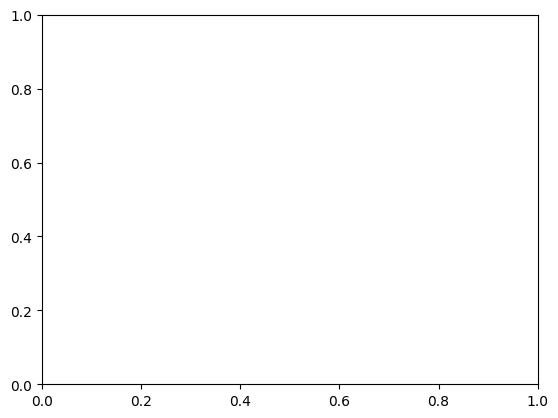

In [102]:
#Graph 1
plt.bar(d_list, time1)
plt.xlabel('Dimension')
plt.ylabel('Speed up factor')
plt.title(factors[0])
plt.show()

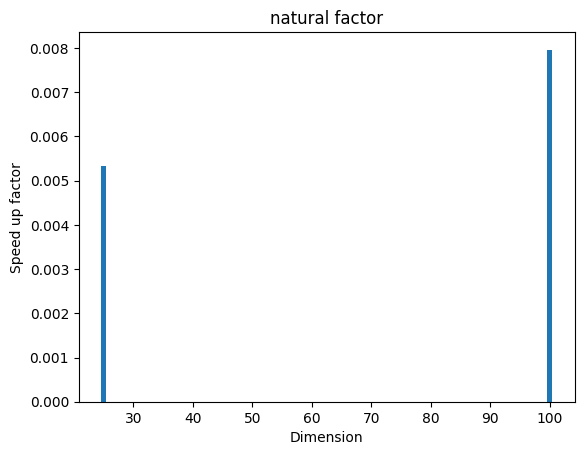

In [ ]:

plt.bar(d_list, time2)
plt.xlabel('Dimension')
plt.ylabel('Speed up factor')
plt.title(factors[1])
plt.show()